In [1]:
import networkx as nx
import numpy as np
import pydot
from grakel import Graph
import pandas as pd
ndf = pd.read_pickle('../IR/graph_IR.pickle')
import warnings
# Ignore DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
def networkx_to_grakel(graph):
    nodes = sorted(graph.nodes(data=True))
    node_mapping = {old: new for new, old in enumerate(graph.nodes())}
    node_labels = {node_mapping[n[0]]: n[1].get('label', str(n[0])) for n in nodes}
    edge_labels = {(node_mapping[u], node_mapping[v]): graph[u][v].get('label', 'edge') for u, v in graph.edges()}
    numerical_edge_labels = {k: hash(v) for k, v in edge_labels.items()}
    edges = [(node_mapping[u], node_mapping[v], numerical_edge_labels.get((node_mapping[u], node_mapping[v]), 0)) for u, v in graph.edges()]
    return Graph(edges, node_labels)


In [3]:
def dot_string_to_networkx(dot_str):
    return read_dot(io.StringIO(dot_str))

def dot_to_networkx(dot_graph):
    return nx.nx_pydot.from_pydot(dot_graph)

def graph_to_dot(dot_graph):
    return  pydot.graph_from_dot_data(dot_graph)[0]

In [4]:
ndf['dot_graph'] = ndf['inter'].apply(graph_to_dot)

In [5]:
ndf['graph_nx'] = ndf['dot_graph'].apply(dot_to_networkx)

In [6]:
ndf['graph_grakel'] = ndf['graph_nx'].apply(networkx_to_grakel)

In [7]:
# Compute the Weisfeiler-Lehman kernel
from grakel.kernels import WeisfeilerLehman
gk = WeisfeilerLehman(n_iter=100, normalize=True)
K = gk.fit_transform(ndf['graph_grakel'])

In [8]:
import numpy as np

def kernel_to_distance_matrix(K):
    num_graphs = K.shape[0]
    D = np.zeros((num_graphs, num_graphs))
    
    for i in range(num_graphs):
        for j in range(num_graphs):
            D[i, j] = np.sqrt(K[i, i] + K[j, j] - 2 * K[i, j])
    
    return D

# Convert the kernel matrix K to a distance matrix D
dist_matrix = kernel_to_distance_matrix(K)

In [9]:
# Get the row and column indices of the maximum value
row_idx, col_idx = np.unravel_index(np.argmax(dist_matrix, axis=None), dist_matrix.shape)

# Print the indices and the maximum value
print(f"The maximum value is at row {row_idx} and column {col_idx}, with a value of {dist_matrix[row_idx, col_idx]}")

The maximum value is at row 3 and column 55, with a value of 1.413416415409981


In [10]:
dist_matrix[row_idx, col_idx]

1.413416415409981

In [11]:
# Get the flattened indices sorted by their corresponding values in ascending order
sorted_indices = np.argsort(-dist_matrix.flatten())

# Convert the sorted flattened indices back to row and column format
sorted_pairs = np.array(np.unravel_index(sorted_indices, dist_matrix.shape)).T

# Print the pairs from most to least similar (smallest to largest distance)
for pair in sorted_pairs[9800:10000]:
    row_idx, col_idx = pair
    print(f"Pair: ({row_idx}, {col_idx}), Distance: {dist_matrix[row_idx, col_idx]}")

Pair: (13, 33), Distance: 1.4092727453030174
Pair: (82, 33), Distance: 1.4092727453030174
Pair: (33, 13), Distance: 1.4092727453030174
Pair: (12, 83), Distance: 1.4092727453030174
Pair: (33, 91), Distance: 1.4092727453030174
Pair: (31, 12), Distance: 1.4092727453030174
Pair: (58, 83), Distance: 1.4092727453030174
Pair: (58, 31), Distance: 1.4092727453030174
Pair: (83, 12), Distance: 1.4092727453030174
Pair: (33, 82), Distance: 1.4092727453030174
Pair: (10, 41), Distance: 1.408794463345183
Pair: (41, 59), Distance: 1.408794463345183
Pair: (41, 10), Distance: 1.408794463345183
Pair: (59, 41), Distance: 1.408794463345183
Pair: (7, 10), Distance: 1.4086456739235214
Pair: (10, 7), Distance: 1.4086456739235214
Pair: (7, 59), Distance: 1.4086456739235214
Pair: (7, 39), Distance: 1.4086456739235214
Pair: (7, 30), Distance: 1.4086456739235214
Pair: (7, 1), Distance: 1.4086456739235214
Pair: (39, 7), Distance: 1.4086456739235214
Pair: (30, 7), Distance: 1.4086456739235214
Pair: (59, 7), Distance

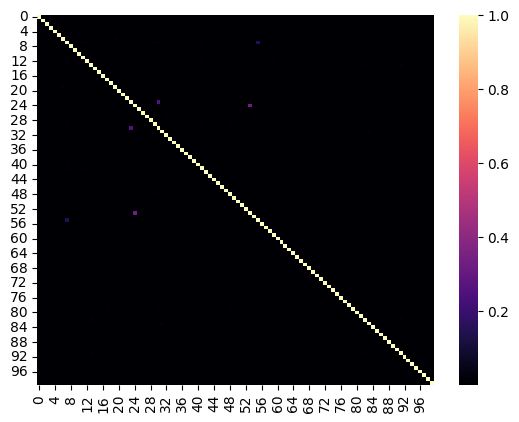

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create heatmap from dist_matrix
sns.heatmap(K, cmap='magma')
plt.show()

In [76]:
from sklearn.cluster import KMeans
# Determine the optimal number of clusters
distortions = []
K = range(1, 100)
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init='auto').fit(dist_matrix)
    distortions.append(kmeanModel.inertia_)

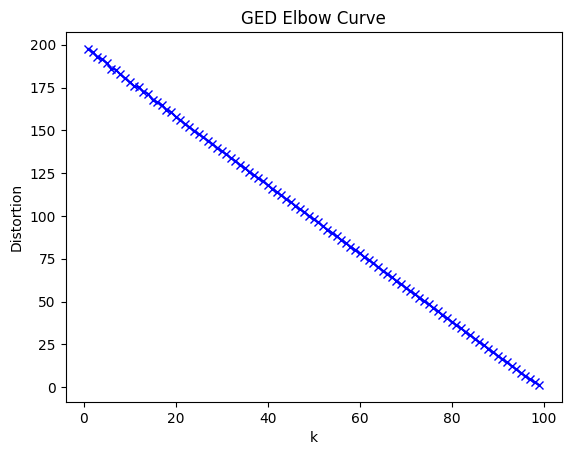

In [77]:
import matplotlib.pyplot as plt
# Plot the elbow curve to determine the optimal number of clusters
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('GED Elbow Curve')
plt.show()

In [28]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
# Use the optimal number of clusters to perform K-means clustering
n_clusters = 10 # Example of using 3 clusters
scaler = StandardScaler()
dist_matrix_scaled = scaler.fit_transform(dist_matrix)
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0, n_init=10)
labels = kmeans.fit_predict(dist_matrix_scaled)

# Print the labels assigned to each data point
print(labels)

[6 4 6 9 6 2 1 4 6 3 4 4 4 3 6 6 8 0 6 1 6 6 6 5 7 6 6 6 6 4 5 8 6 3 6 6 6
 6 3 4 6 4 6 6 6 8 3 6 0 6 6 6 6 7 6 4 6 6 8 4 6 6 9 6 6 6 6 6 1 6 6 3 6 6
 6 4 6 1 0 0 6 3 3 8 6 6 6 6 6 6 4 3 6 6 6 6 6 3 6 6]


In [34]:
# Get unique values and count them
unique_values = set(labels)
len(unique_values)

10

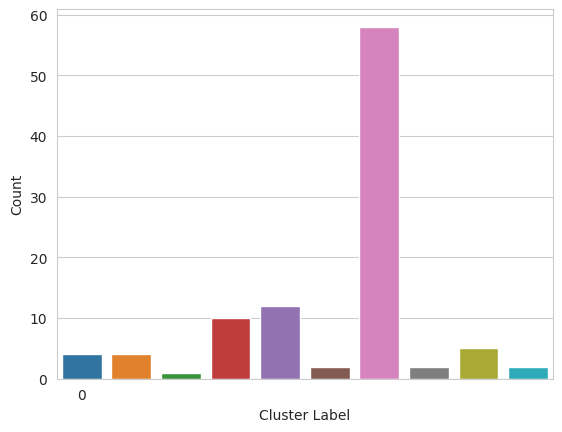

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
ax = sns.countplot(x=labels)
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Count')
ax.set_xticks(range(0, n_clusters, 10))
ax.set_xticklabels(range(0, n_clusters, 10))

plt.show()

In [31]:
ndf['guess'] = labels

In [35]:
# Get the count of each label
label_counts = ndf['guess'].value_counts()

# Print the label counts
print(label_counts)

6    58
4    12
3    10
8     5
1     4
0     4
9     2
5     2
7     2
2     1
Name: guess, dtype: int64


In [36]:
ndf[ndf['guess'] == 6].index

Int64Index([ 0,  2,  4,  8, 14, 15, 18, 20, 21, 22, 25, 26, 27, 28, 32, 34, 35,
            36, 37, 40, 42, 43, 44, 47, 49, 50, 51, 52, 54, 56, 57, 60, 61, 63,
            64, 65, 66, 67, 69, 70, 72, 73, 74, 76, 80, 84, 85, 86, 87, 88, 89,
            92, 93, 94, 95, 96, 98, 99],
           dtype='int64')

In [13]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Scale the data
scaler = StandardScaler()
dist_matrix_scaled = scaler.fit_transform(dist_matrix)

# Determine the optimal number of clusters using silhouette analysis
best_n_clusters = 2
best_silhouette_score = -1

for n_clusters in range(2, 100):  # Assuming you want to test from 2 to 10 clusters
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0, n_init=10)
    labels = kmeans.fit_predict(dist_matrix_scaled)
    silhouette_avg = silhouette_score(dist_matrix_scaled, labels)
    
    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters
        print(silhouette_avg)

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=best_n_clusters, init='k-means++', random_state=0, n_init=10)
labels = kmeans.fit_predict(dist_matrix_scaled)

0.00048619650067497884
0.004423197632456154
0.007306819971018715
0.007403725637183916
0.007433250593032591
0.008690019625418786
0.008695109819203175
0.008697962296896747
0.008750258749631468
0.008788767464073357


In [25]:
# Get unique values and count them
unique_values = set(labels)
len(unique_values)

25

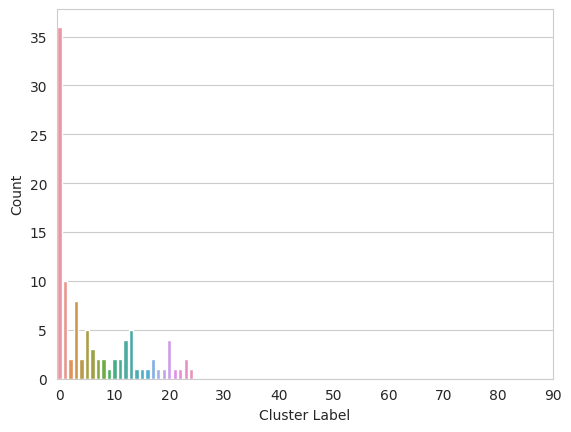

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
ax = sns.countplot(x=labels)
ax.set_xlabel('Cluster Label')
ax.set_ylabel('Count')
ax.set_xticks(range(0, n_clusters, 10))
ax.set_xticklabels(range(0, n_clusters, 10))

plt.show()

In [22]:
ndf['sil'] = labels

In [23]:
# Get the count of each label
label_counts = ndf['sil'].value_counts()

# Print the label counts
print(label_counts)

0     36
1     10
3      8
13     5
5      5
12     4
20     4
6      3
7      2
4      2
10     2
17     2
2      2
23     2
8      2
11     2
22     1
15     1
9      1
16     1
14     1
24     1
21     1
18     1
19     1
Name: sil, dtype: int64


In [37]:
ndf[ndf['sil'] == 0].index

Int64Index([ 2,  4, 14, 18, 20, 21, 25, 28, 37, 40, 42, 43, 44, 47, 49, 50, 51,
            52, 56, 57, 60, 63, 65, 66, 67, 70, 74, 76, 85, 86, 87, 89, 92, 94,
            95, 98],
           dtype='int64')

In [42]:
ndf.to_pickle('gk_results.pickle')

In [43]:
df = pd.read_pickle('gk_results.pickle')

In [44]:
df

,path,inter,dot_graph,graph_nx,graph_grakel,sil,guess
0,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1644 [label=""category_nam...","digraph graphname {\n1644 [label=""category_nam...","(1644, 1643, 1642, \n)",<grakel.graph.Graph object at 0x7fe32f19a740>,9,6
1,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1647 [label=""var: db.secr...","digraph graphname {\n1647 [label=""var: db.secr...","(1647, 1646, 1649, 1648, 1645, \n)",<grakel.graph.Graph object at 0x7fe32f19a7d0>,3,4
2,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1651 [label=""enabled: Tru...","digraph graphname {\n1651 [label=""enabled: Tru...","(1651, 1650, \n)",<grakel.graph.Graph object at 0x7fe32f19a8c0>,0,6
3,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1654 [label=""msg: This is...","digraph graphname {\n1654 [label=""msg: This is...","(1654, 1653, 1656, 1655, 1658, 1657, 1652, \n)",<grakel.graph.Graph object at 0x7fe32f19a920>,8,9
4,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1660 [label=""repo: deb ht...","digraph graphname {\n1660 [label=""repo: deb ht...","(1660, 1659, \n)",<grakel.graph.Graph object at 0x7fe32f19aad0>,0,6
...,...,...,...,...,...,...,...
95,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1961 [label=""name: Displa...","digraph graphname {\n1961 [label=""name: Displa...","(1961, 1960, \n)",<grakel.graph.Graph object at 0x7fe32f1872b0>,0,6
96,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1964 [label=""var: {{ rand...","digraph graphname {\n1964 [label=""var: {{ rand...","(1964, 1963, 1965, 1962, \n)",<grakel.graph.Graph object at 0x7fe32efe92a0>,19,6
97,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1968 [label=""image: nginx...","digraph graphname {\n1968 [label=""image: nginx...","(1968, 1967, 1966, \n)",<grakel.graph.Graph object at 0x7fe32f1871f0>,1,3
98,/data/minh/CompilierFuzzing/similarity/YAML/ch...,"digraph graphname {\n1970 [label=""command: ans...","digraph graphname {\n1970 [label=""command: ans...","(1970, 1969, \n)",<grakel.graph.Graph object at 0x7fe32f187160>,0,6


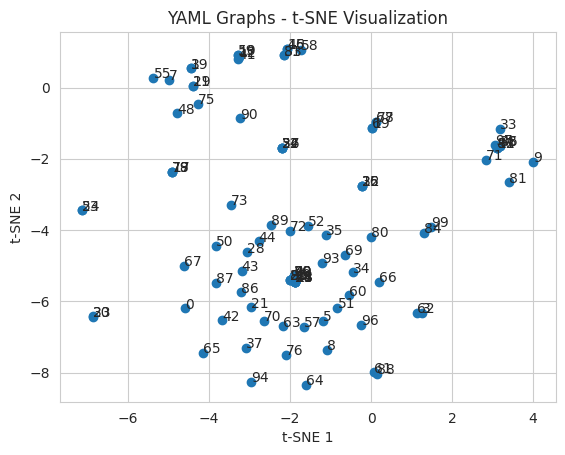

In [47]:
# Assume you have a distance matrix called 'dist_matrix'

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_data = tsne.fit_transform(dist_matrix)

# Separate the 2D coordinates
x_coords = reduced_data[:, 0]
y_coords = reduced_data[:, 1]

# Create a scatter plot
plt.scatter(x_coords, y_coords)

# Label each point with its index (optional)
for i, txt in enumerate(range(len(x_coords))):
    plt.annotate(txt, (x_coords[i], y_coords[i]))

# Display the plot
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('YAML Graphs - t-SNE Visualization')
plt.show()

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import umap

# Assume you have a distance matrix called 'dist_matrix'

# Use UMAP for dimensionality reduction
reducer = umap.UMAP(n_components=2, metric='precomputed', random_state=42)
reduced_data = reducer.fit_transform(dist_matrix)

# Separate the 2D coordinates
x_coords = reduced_data[:, 0]
y_coords = reduced_data[:, 1]

# Create a scatter plot
plt.scatter(x_coords, y_coords)

# Label each point with its index (optional)
for i, txt in enumerate(range(len(x_coords))):
    plt.annotate(txt, (x_coords[i], y_coords[i]))

# Display the plot
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('YAML Graphs - UMAP Visualization')
plt.show()

AttributeError: module 'umap' has no attribute 'UMAP'